In [2]:
from nba_api.stats.static import teams
import pandas as pd 


In [3]:
OKC_data  = teams.find_teams_by_full_name("Oklahoma City Thunder")
OKC_id = OKC_data[0]['id'] # 1610612760 team id 

PAC_data = teams.find_teams_by_full_name("Indiana Pacers")
PAC_id = PAC_data[0]['id'] # 1610612754 team id 

In [4]:
from nba_api.stats.endpoints import leaguegamefinder

finder = leaguegamefinder.LeagueGameFinder(
player_or_team_abbreviation= "T",
team_id_nullable=1610612760,
date_from_nullable="06/05/2025",
date_to_nullable="06/05/2025"
)

g1 = finder.get_data_frames()[0] 
g1_id= g1["GAME_ID"] #0042400401	


# Players Data

In [5]:
from nba_api.stats.endpoints import boxscoretraditionalv2
box = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=g1_id)
players = box.player_stats.get_data_frame()
players.to_csv("player_data.csv")

# Team Data

In [6]:
teams = box.team_stats.get_data_frame()
teams.to_csv("team_data.csv")

# Advanced player and team stats

In [7]:
from nba_api.stats.endpoints import boxscoreadvancedv2
adv_box = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=g1_id)
adv_player_df = adv_box.player_stats.get_data_frame() #advanced player stats

adv_team_df = adv_box.team_stats.get_data_frame()
adv_team_df.to_csv("adv_team.csv")#advanced team stats

In [8]:
adv_player_df.to_csv("adv_players.csv")

# Play by play data

In [9]:
from nba_api.stats.endpoints import playbyplayv2
pbp = playbyplayv2.PlayByPlayV2(game_id=g1_id)
pbp_df = pbp.get_data_frames()[0]
pbp_df # play by play stats 
pbp_df.to_csv("plays.csv")

# Hustle stats

In [10]:
from nba_api.stats.endpoints import BoxScoreHustleV2

hustle = BoxScoreHustleV2(game_id=g1_id)
hustle_df = hustle.get_data_frames()[0]
hustle_df.to_csv("hustle.csv")

# Win Probability PBP

In [11]:
from nba_api.stats.endpoints import WinProbabilityPBP

w_pct_pbp = WinProbabilityPBP(game_id=g1_id,run_type="each second")
w_pct_pbp_df = w_pct_pbp.get_data_frames()[0]
w_pct_pbp_df.to_csv("win_prob.csv")

In [12]:
from nba_api.stats.endpoints import CommonTeamRoster, ShotChartDetail

team_id     = PAC_id        
season      = '2024-25'            # full season string
season_type = 'Playoffs'           # 'Regular Season' | 'Pre Season' | 'Playoffs' | 'All Star'
game_id     = g1_id        
# ────────────────────────────────────────────────────────────────────────────────

# 1. Fetch the team’s roster for the season
roster = CommonTeamRoster(team_id=team_id, season=season)
roster_df = roster.get_data_frames()[0]
player_ids = roster_df['PLAYER_ID'].tolist()

# 2. Loop through each player and pull their shot chart detail for that game
shots_list = []
for pid in player_ids:
    shot_detail = ShotChartDetail(
        context_measure_simple   = 'PTS',
        last_n_games             = 0,
        league_id                = '00',
        season_type_all_star     = season_type,
        season_nullable          = season,
        team_id                  = 0,
        player_id                = pid,
        game_id_nullable         = game_id,
        date_from_nullable       = '06/05/2025',
        date_to_nullable         = '06/05/2025',
        game_segment_nullable    = '',
        period                   = 0,
        outcome_nullable         = '',
        location_nullable        = '',
        month                    = 0,
        vs_conference_nullable   = '',
        vs_division_nullable     = '',
        opponent_team_id         = 0,
        rookie_year_nullable     = '',
        season_segment_nullable  = '',
        start_period_nullable    = '',
        end_period_nullable      = '',
        start_range_nullable     = '',
        end_range_nullable       = '',
        range_type_nullable      = '',
        point_diff_nullable      = '',
        position_nullable        = '',
        player_position_nullable = ''
    )
    # [0] = LeagueAverages, [1] = Shot_Chart_Detail
    _, df_shots = shot_detail.get_data_frames()
    if not df_shots.empty:
        shots_list.append(df_shots)
team_shot_detail_df = pd.concat(shots_list, ignore_index=True)

# Four Factors

In [13]:
from nba_api.stats.endpoints import boxscorefourfactorsv2
start_period = 1             # period to start (1 = Q1)
end_period   = 4             # period to end (4 = Q4; use 5 for OT if needed)
range_type   = 0             # 0 = entire period range
start_range  = 0             # seconds into period to start (0 = beginning)
end_range    = 0             # seconds into period to end (0 = full period)

four_factors = boxscorefourfactorsv2.BoxScoreFourFactorsV2(
    game_id    = g1_id,
    start_period = start_period,
    end_period   = end_period,
    range_type   = range_type,
    start_range  = start_range,
    end_range    = end_range
)


players_four_factors, teams_four_factors = four_factors.get_data_frames()

players_four_factors.to_csv("players_four_factors.csv")

In [14]:
teams_four_factors.to_csv("teams_four_factors.csv")

In [15]:
teams_four_factors

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT
0,0042400401,1610612760,Thunder,OKC,Oklahoma City,240.000000:00,0.454,0.245,0.066,0.164,0.585,0.256,0.242,0.348
1,0042400401,1610612754,Pacers,IND,Indiana,240.000000:00,0.585,0.256,0.242,0.283,0.454,0.245,0.066,0.262


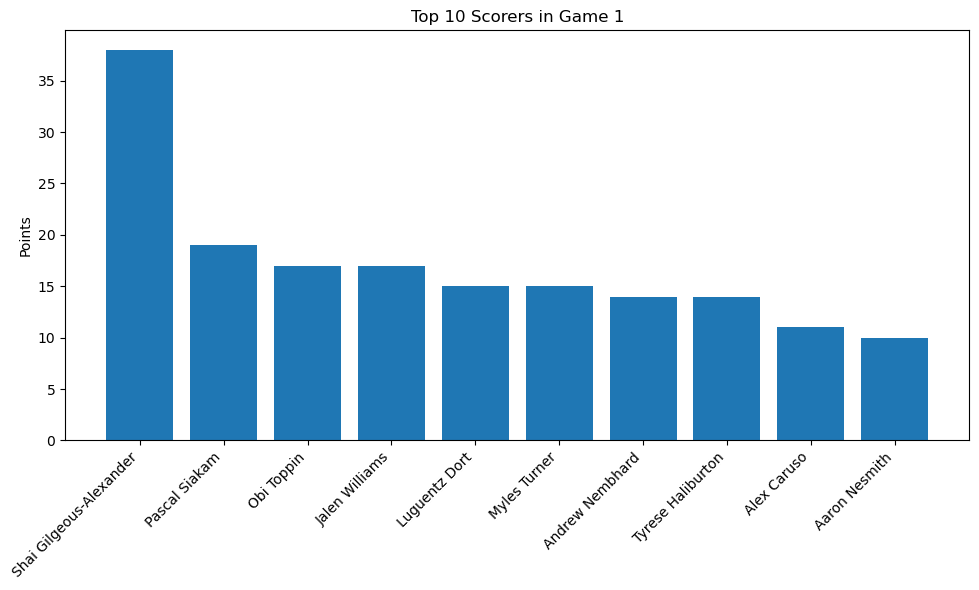

In [16]:
import matplotlib.pyplot as plt

# sort and pick top 10
top_scorers = players.sort_values('PTS', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_scorers['PLAYER_NAME'], top_scorers['PTS'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Scorers in Game 1')
plt.ylabel('Points')
plt.tight_layout()
plt.show()

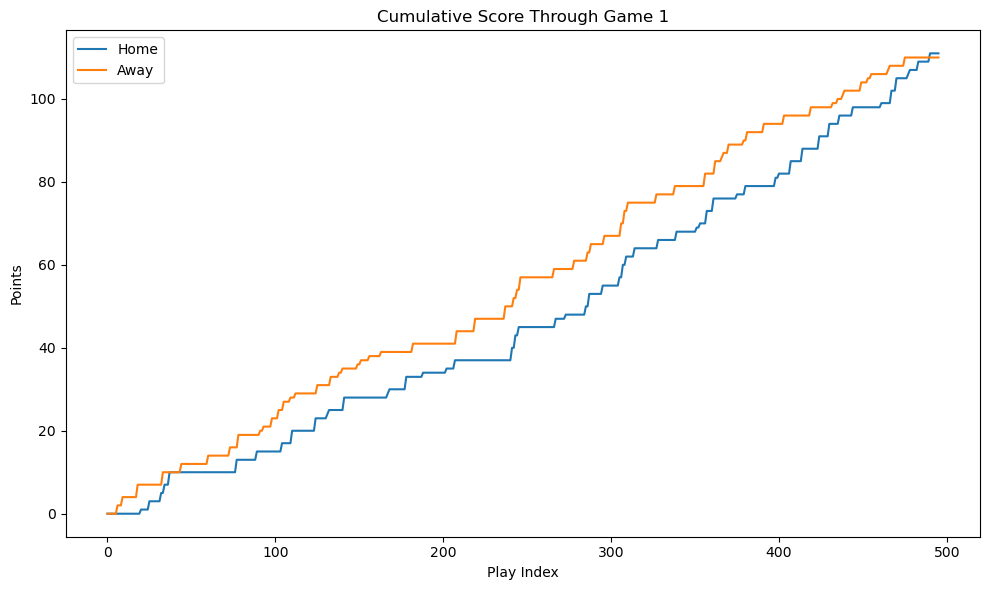

In [20]:
# extract numeric home/away scores
scores = pbp_df['SCORE'].fillna('0-0').str.split('-', expand=True).astype(int)
pbp_df['HOME_PTS'] = scores[0]
pbp_df['AWAY_PTS'] = scores[1]

# cumulative sum
pbp_df['HOME_CUM'] = pbp_df['HOME_PTS'].cummax()
pbp_df['AWAY_CUM'] = pbp_df['AWAY_PTS'].cummax()

plt.figure(figsize=(10, 6))
plt.plot(pbp_df.index, pbp_df['HOME_CUM'], label='Home')
plt.plot(pbp_df.index, pbp_df['AWAY_CUM'], label='Away')

plt.title('Cumulative Score Through Game 1')
plt.xlabel('Play Index')
plt.ylabel('Points')
plt.legend()
plt.tight_layout()
plt.show()


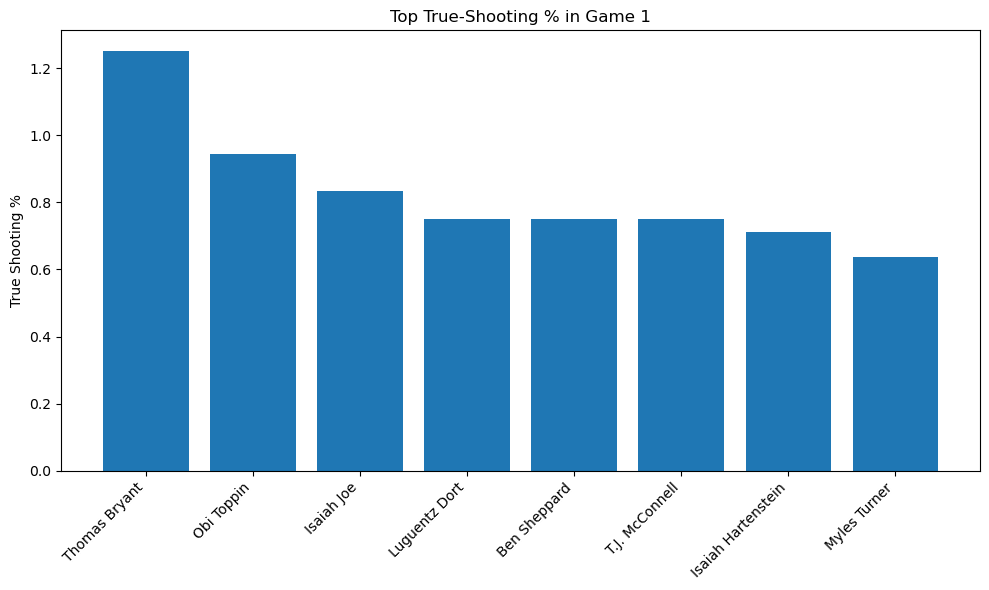

In [21]:
# convert to percent (if 0–1 scale)
if adv_player_df['TS_PCT'].max() <= 1:
    adv_player_df['TS_PCT'] *= 100

ts_leaders = adv_player_df.sort_values('TS_PCT', ascending=False).head(8)

plt.figure(figsize=(10, 6))
plt.bar(ts_leaders['PLAYER_NAME'], ts_leaders['TS_PCT'])
plt.xticks(rotation=45, ha='right')
plt.title('Top True-Shooting % in Game 1')
plt.ylabel('True Shooting %')
plt.tight_layout()
plt.show()


In [24]:
teams_four_factors.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_NAME', 'TEAM_ABBREVIATION', 'TEAM_CITY',
       'MIN', 'EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', 'OREB_PCT', 'OPP_EFG_PCT',
       'OPP_FTA_RATE', 'OPP_TOV_PCT', 'OPP_OREB_PCT'],
      dtype='object')

In [25]:
import plotly.express as px

# pick the four factors from your DataFrame
cols = ['EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', 'OREB_PCT']
df = teams_four_factors.copy()

# If these are on a 0–1 scale, convert to percentages
for c in cols:
    if df[c].max() <= 1:
        df[c] *= 100

fig = px.bar(
    df,
    x='TEAM_ABBREVIATION',
    y=cols,
    barmode='group',
    labels={'value':'Percent', 'variable':'Factor'},
    title='Team Four-Factors Comparison – Game 1'
)
fig.update_layout(xaxis_title='', legend_title='')
fig.show()
